In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gdown
import random
import pickle

In [2]:
# Установка устройства
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

### Метрики качества

In [3]:
def precision_at_k(relevant, predicted, k: int = 10):
    """ 
        Функиця расчета Precision@k
        relevant - релевантные items для одного пользователя
        predicted - рекомендованные items для одного пользователя
    """
    return len(set(relevant[:k]) & set(predicted[:k]))/k 

def rel_item(relevant, predicted):
    """
        Функция рассчитывает количество релевантных Item
    """
    result = [0]*max(len(relevant), len(predicted))
    items = min(len(relevant), len(predicted))
    for i in range(items):
        result[i] = int(relevant[i] == predicted[i])
    return result  


def ap_at_k(relevant, predicted, k: int = 10):
    """ 
        Функция расчета AP@k
        relevant - релевантные items для одного пользователя
        predicted - рекомендованные items для одного пользователя
    """
    y_i = rel_item(relevant=relevant, predicted=predicted)
    p_at_i = [0]*k
    iter_cnt = min(len(relevant), k)
    for i in range(1, iter_cnt+1):
        p_at_i[i-1] = precision_at_k(relevant=relevant, predicted=predicted, k=i)
    return sum([y*p/k for y, p in zip(y_i, p_at_i)])

def map_at_k(relevant, predicted, k: int = 10):
    """ 
        Функция расчета MAP@k
        relevant список по всем пользователям с их релевантными items
        predicted список по всем пользователям с их рекомендованными items
    """
    users = len(relevant)
    sum_apk = 0
    for user in range(users):
        sum_apk += ap_at_k(relevant=relevant[user], predicted=predicted[user], k=k)
    return sum_apk/users


def nap_at_k(relevant, predicted, k: int = 10):
    """ 
        Функция расчета normalize AP@k
        relevant - релевантные items для одного пользователя
        predicted - рекомендованные items для одного пользователя
    """
    y_i = rel_item(relevant=relevant, predicted=predicted)
    p_at_i = [0]*k
    k = min(len(relevant), k)
    for i in range(1, k+1):
        p_at_i[i-1] = precision_at_k(relevant=relevant, predicted=predicted, k=i)
    return sum([y*p/k for y, p in zip(y_i, p_at_i)])

def mnap_at_k(relevant, predicted, k: int = 10):
    """ 
        Функция расчета MAP@k
        relevant список по всем пользователям с их релевантными items
        predicted список по всем пользователям с их рекомендованными items
    """
    users = len(relevant)
    sum_napk = 0
    for user in range(users):
        sum_napk += nap_at_k(relevant=relevant[user], predicted=predicted[user], k=k)
    return sum_napk/users


def hitrate_at_k(relevant, predicted, k: int = 10):
    """
        Функция расчета Hitrate@k
        relevant список по всем пользователям с их релевантными items
        predicted список по всем пользователям с их рекомендованными items
    """
    
    cnt_user = len(predicted) # Количество пользователей    
    cnt_valid_user = 0
    for user in range(cnt_user):
        cnt_valid_user += int(len(set(relevant[user][:k]) & set(predicted[user][:k])) > 0) 

    return cnt_valid_user/cnt_user


def ndsg_at_k(relevant, predicted, k: int = 10):
    """
        Функция расчета nDSG@k
        relevant - релевантные items для одного пользователя
        predicted - рекомендованные items для одного пользователя
    """
    idsg_at_k = sum([1/np.log2(k+1) for k in range(1, k+1)])
    k = min(len(relevant), k)
    dsg_at_k = 0
    for k in range(1, k+1):
        dsg_at_k += int(relevant[k-1] == predicted[k-1])/np.log2(k+1)
    return dsg_at_k/idsg_at_k

### Подготовка данных

In [4]:
# Загрузка данных о транзакциях
gdown.download(url="https://drive.google.com/uc?export=download&id=18s2x14ttYJ-wXjhCEFFtuSwLSOBP5hpC",  
               output="transactions.csv",
               quiet=False)
main_df = pd.read_csv("transactions.csv", index_col=0)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=18s2x14ttYJ-wXjhCEFFtuSwLSOBP5hpC
From (redirected): https://drive.google.com/uc?export=download&id=18s2x14ttYJ-wXjhCEFFtuSwLSOBP5hpC&confirm=t&uuid=b05fcd7b-df93-444f-ba43-116c317be273
To: /home/noname/projects/NN/Next-Basket-Recommendation/transactions.csv
100%|██████████| 1.05G/1.05G [01:43<00:00, 10.2MB/s]


In [5]:
# Кодировщик всех пользователей и продуктов
user_to_id = {val: i for i, val in enumerate(sorted(main_df['user_id'].unique()))}
product_to_id = {val: i+2 for i, val in enumerate(sorted(main_df['product_id'].unique()))}
# Признаки начала и конца последовательности
product_to_id["SOS"] = 0
product_to_id["EOS"] = 1
# Кодирование пользователей
main_df["user_id"] = main_df["user_id"].map(lambda x: user_to_id[x])
# Декодировщик
id_to_user = {id: user for user, id  in user_to_id.items()}
id_to_product = {id: product for product, id  in product_to_id.items()}

# Выгрузка кодировщиков
with open('product_to_id.pickle', 'wb') as handle:
    pickle.dump(product_to_id, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('user_to_id.pickle', 'wb') as handle:
    pickle.dump(user_to_id, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('id_to_product.pickle', 'wb') as handle:
    pickle.dump(id_to_product, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('id_to_user.pickle', 'wb') as handle:
    pickle.dump(id_to_user, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# Формирование датафрейма с последовательностями
seq_df = (
    main_df
    .sort_values(by=["user_id", "order_number", "add_to_cart_order"])
    .groupby(["user_id", "order_number"], as_index=False)["product_id"]
    .agg(list)
)

In [7]:
# Формировние тестовых данных
seq_df["invers_index"] = (
    seq_df
    .sort_values(by=["user_id", "order_number"], ascending=[True, False])
    .groupby(["user_id"], as_index=False).cumcount()
)
# Разделение данных
test_seq = (
    seq_df[seq_df["invers_index"].isin([i for i in range(0, 6)])]
    .drop(columns="invers_index"))
# Оставляю только последние 6 корзин (5 на вход и 1 таргет)
train_seq = ( 
    seq_df[seq_df["invers_index"].isin([i for i in range(1, 7)])]
    .drop(columns="invers_index")
)
# Последние 5 корзин для инференса
inferece_seq = (
    seq_df[seq_df["invers_index"].isin([i for i in range(0, 5)])]
    .drop(columns="invers_index"))

inferece_seq.to_parquet("users_baskets.parquet")

In [8]:
train_seq.head(10)

,user_id,order_number,product_id
3,0,4,"[196, 12427, 10258, 25133, 26405]"
4,0,5,"[196, 12427, 10258, 25133, 10326, 17122, 41787..."
5,0,6,"[196, 12427, 10258, 25133]"
6,0,7,"[196, 10258, 12427, 25133, 13032]"
7,0,8,"[12427, 196, 10258, 25133, 46149, 49235]"
8,0,9,"[49235, 46149, 25133, 196, 10258, 12427]"
17,1,8,"[32792, 28918, 24852, 34688, 48110, 47209, 320..."
18,1,9,"[32792, 24852, 12000, 21376, 2002, 7781, 13742..."
19,1,10,"[24852, 12000, 47209, 17872, 18523, 1559, 1915..."
20,1,11,"[32792, 4071, 19051, 19156, 18523, 1559, 22124..."


In [9]:
# Формирование последовательности из корзин клиента
def make_seq(inpt):
    ans = []
    for lst in inpt:
        ans += lst
    return ans

In [10]:
def convert_seq(dict_idxs, seq):
    """
        Перевод значения в индекс
    """
    seq = [dict_idxs[val] for val in seq]
    return seq

def convert_to_tensor(pair):
    """ 
        Возвращает тензоры
    """
    inp = torch.tensor(pair[0], dtype=torch.long, device=device).view(-1, 1)
    trgt = torch.tensor(pair[1], dtype=torch.long, device=device).view(-1, 1)
    return (inp, trgt)


In [11]:
# Формирование списков последовательностей
def get_seqs_of_df(df, id_to_user, prod_to_id):
    pairs = []
    for user in id_to_user.keys():
        sample = df[df["user_id"] == user] 
        n = len(sample)
        if n > 0:
            for i in range(4, n):
                if i < n-1:
                    inpt = sample["product_id"].iloc[i-4:i+1]
                    inpt = make_seq(inpt=inpt)
                    inpt = convert_seq(dict_idxs=prod_to_id, seq=inpt)
                    target = sample["product_id"].iloc[i+1]
                    target = convert_seq(dict_idxs=prod_to_id, seq=target)
                    pairs.append((inpt, target))
    return pairs

In [12]:
# Формирование списков последовательностей
def get_seqs_for_test(df, id_to_user, prod_to_id):
    inputs = []
    targets = []
    for user in id_to_user.keys():
        sample = df[df["user_id"] == user] 
        n = len(sample)
        if n > 0:
            for i in range(4, n):
                if i < n-1:
                    inpt = sample["product_id"].iloc[i-4:i+1]
                    inpt = make_seq(inpt=inpt)
                    inputs.append(inpt) 
                    target = sample["product_id"].iloc[i+1]
                    targets.append(target)
    return inputs, targets

In [13]:
%%time
# Последовательности для обучения
train_pairs = get_seqs_of_df(df=train_seq, id_to_user=id_to_user, prod_to_id=product_to_id)
# Последовательности для тестирования
val_input, val_target = get_seqs_for_test(df=test_seq, id_to_user=id_to_user, prod_to_id=product_to_id)

CPU times: user 1min 16s, sys: 49.7 ms, total: 1min 16s
Wall time: 1min 16s


In [14]:
MAX_LENGTH = 630  # Максимальная длина продуктов из последних 5 корзин
SOS_token = 0
EOS_token = 1

### Модель 
</br> Next Bascet model: Sec2Sec модель, которая включает encoder и decoder с рекурентными слоями.


**Encoder**

In [15]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

**Decoder**

In [16]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        

    def forward(self, input, hidden, _):
        output = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Обучение

In [17]:
def train(input_tensor, target_tensor, 
          encoder, decoder, 
          encoder_optimizer, decoder_optimizer, 
          criterion, use_teacher_forcing = True, 
          max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]

    else:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            _, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [18]:
def get_train_graph(points, step):
    """ 
        Функция для отрисовки 
    """
    clear_output()
    plt.figure(figsize=(10, 5))
    plt.plot([i * step for i in range(1, len(points)+1)], points)
    plt.grid()
    plt.title("Loss function")
    plt.xlabel("num iter")
    plt.ylabel("loss")
    plt.show()
    

In [22]:
def trainIters(encoder, decoder, n_iters,
               print_every=1000, plot_every=1000, 
               learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [convert_to_tensor(random.choice(train_pairs)) 
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if print_every is not None and iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(%d %d%%) %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

        if plot_every is not None and iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            get_train_graph(plot_losses, plot_every)

In [20]:
# Инициализация моделей
hidden_size = 128
encoder0 = EncoderRNN(len(product_to_id.keys())+3, hidden_size).to(device)
decoder0 = DecoderRNN(hidden_size, len(product_to_id.keys())+3).to(device)
# Загрузка весов предыдущих экспериментов
# encoder0.load_state_dict(torch.load("encoder.pt"))
# decoder0.load_state_dict(torch.load("decoder.pt"))

<All keys matched successfully>

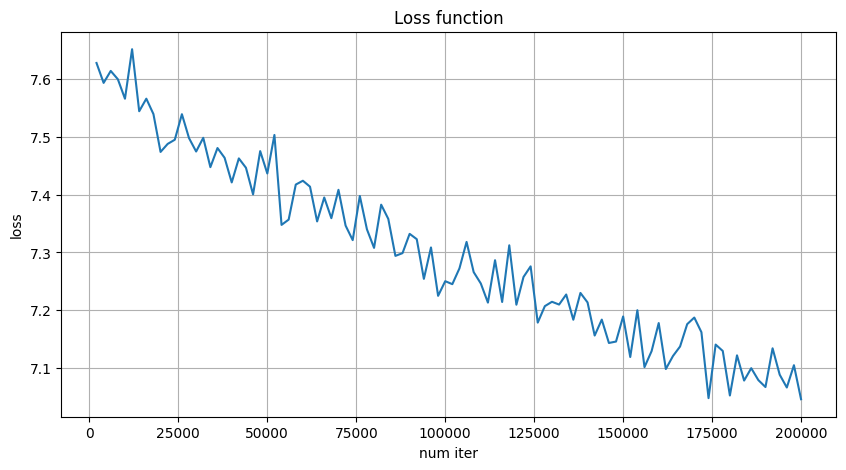

CPU times: user 1h 53min 40s, sys: 44.1 s, total: 1h 54min 24s
Wall time: 1h 54min 22s


In [29]:
%%time
# Обучение модели
trainIters(encoder0, decoder0, n_iters=200000,
        print_every=None, plot_every=2000)

In [30]:
# Сохранение весов модели
torch.save(encoder0.state_dict(), "encoder_1.pt")
torch.save(decoder0.state_dict(), "decoder_1.pt")

### Инференс

In [31]:
def evaluate(encoder, decoder, seq, prod_to_id, k=10, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = convert_seq(prod_to_id, seq)
        input_tensor = torch.tensor(input_tensor, dtype=torch.long, device=device).view(-1, 1)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(k): # Количество слов
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            _, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(id_to_product[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words


In [32]:
%%time
# Предикт по всем пользователям
answers = []
for seq in val_input:
    ans = evaluate(encoder=encoder0,
         decoder=decoder0,
         seq=seq,
         k=10,
         prod_to_id=product_to_id)
    answers.append(ans)

CPU times: user 1h 18min 22s, sys: 965 ms, total: 1h 18min 23s
Wall time: 14min 17s


In [33]:
# Метрики качетсва модели
metrics = {}
metrics["MAP@k"] = map_at_k(relevant=val_target, predicted=answers, k=10)
metrics["MNAP@k"] = mnap_at_k(relevant=val_target, predicted=answers, k=10)
metrics["Hitrate@k"] = hitrate_at_k(relevant=val_target, predicted=answers, k=10)
sum_ndsg = 0
sum_precision = 0
for user in range(len(val_target)):
    rel = val_target[user]
    pred = answers[user]
    sum_ndsg += ndsg_at_k(relevant=rel, predicted=pred, k=10)
    sum_precision += precision_at_k(relevant=rel, predicted=pred, k=10)
metrics["AVG_nDSG@k"] = sum_ndsg/len(val_target)
metrics["AVG_Precision@k"] = sum_precision/len(val_target)

In [34]:
metrics

{'MAP@k': 0.019605186904757547,
 'MNAP@k': 0.03746035197625272,
 'Hitrate@k': 0.59713,
 'AVG_nDSG@k': 0.044378228811807995,
 'AVG_Precision@k': 0.10501500000006163}